In [2]:
#https://www.tensorflow.org/tutorials/keras/classification
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
encoding_dim = 32

#define the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])


In [4]:
# compile the keras model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)


11493376/11490434 [==============================] - 1s 0us/step
Data shapes (10000, 28, 28) (10000,) (60000, 28, 28) (60000,)


In [6]:
# fit the keras model on the dataset
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

# evaluate the keras model
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
# evaluate the keras model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTrain accuracy:', train_acc)
print('\nTest accuracy:', test_acc)

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2526 - accuracy: 0.9282 - val_loss: 0.1327 - val_accuracy: 0.9618
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1101 - accuracy: 0.9672 - val_loss: 0.0944 - val_accuracy: 0.9710
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0765 - accuracy: 0.9767 - val_loss: 0.0916 - val_accuracy: 0.9727
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0563 - accuracy: 0.9831 - val_loss: 0.0773 - val_accuracy: 0.9772
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0444 - accuracy: 0.9856 - val_loss: 0.0742 - val_accuracy: 0.9779
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0340 - accuracy: 0.9899 - val_loss: 0.0759 - val_accuracy: 0.9773
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0282 - accuracy: 0.9913 - val_loss: 0.0772 - val_accuracy:

In [7]:

test_predictions = model.predict(x_test)
train_predictions = model.predict(x_train)

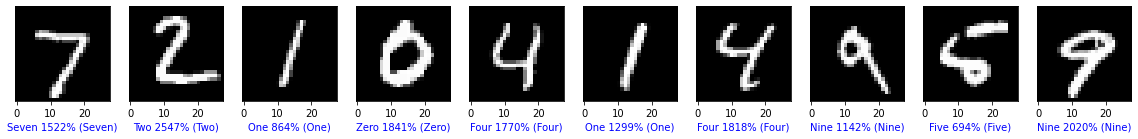

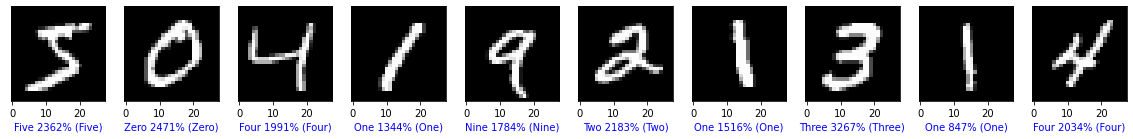

In [8]:
class_names = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']

def display_images(images, predicted_labels, true_labels):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_yaxis().set_visible(False)

        predicted_label = np.argmax(predicted_labels[i])

        if predicted_label == true_labels[i]:
          color = 'blue'
        else:
          color = 'red'

        plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100*np.max(predicted_labels[i]),
                                      class_names[true_labels[i]]),
                                      color=color)


    plt.show()

display_images(x_test, test_predictions, y_test)
display_images(x_train, train_predictions, y_train)

Now, create an FGSM adversarial attack function that perturbs the data using the formula
$$\text{Untargeted: }x' = x + \epsilon.sign(\nabla_xl(x,y))$$

In [9]:
loss_object = keras.losses.CategoricalCrossentropy(from_logits=True )

def single_adversarial_attack(input_image, input_label, eps):
  input_image = tf.cast(input_image.reshape((1, img_rows, img_cols, channels)), tf.float32)
  
  with tf.GradientTape() as tape:
    tape.watch(input_image)

    #Get the predicted output of the i

    prediction = tf.transpose(model(input_image))
    input_label = input_label.reshape((input_label.shape[0],1))
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)

  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)


  output = input_image + signed_grad*eps
  

  return tf.reshape(output,(img_rows, img_cols))

In [10]:
def adversarial_attack(images, labels, eps):
  adv_images = []
  for x, y in zip(images, labels):
    adv_images.append(single_adversarial_attack(x,y,eps).numpy())

  return np.asarray(adv_images)

In [11]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

In [25]:
image = x_train[0]
label = y_train_categorical[0].reshape(y_train_categorical[0].shape[0],1)
x_adv = single_adversarial_attack(image, label, 0.1)


AttributeError: ignored

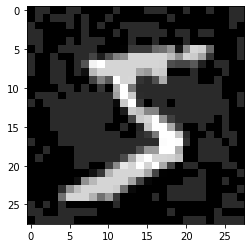

In [13]:
plt.imshow(x_adv)
plt.show()

In [14]:
attack_imgs = adversarial_attack(x_train, y_train_categorical, 0.1)


In [15]:
print("Base accuracy on adversarial images:", model.evaluate(x=attack_imgs, y=y_train, verbose=0))

Base accuracy on adversarial images: [8.730672836303711, 0.17194999754428864]


In [16]:
adv_train_predictions = model.predict(attack_imgs)

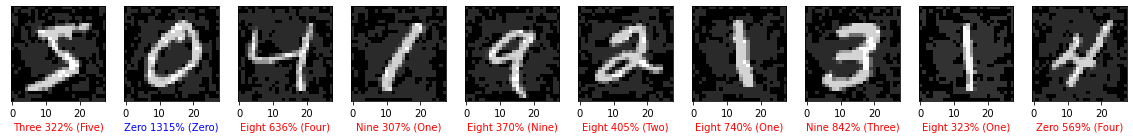

In [17]:
display_images(attack_imgs, adv_train_predictions, y_train)

Now implement a multi-step untargeted PGD adversarial attack using the formula:
$$\text{Untargeted: }x_0' = x \implies x_{N+1}' = Clip_{x,\epsilon}\{x_N' + \alpha.sign(\nabla_xl(x_n', y)\} $$

In [18]:


def single_multistep_adversarial_attack(input_image, input_label, eps, a, T):
  image_temp = tf.cast(input_image.reshape((1, img_rows, img_cols, channels)), tf.float32)
      
      
  for t in range(T):
      
    step_size = (1 - a*t)**(-1)
      
    with tf.GradientTape() as tape:
      tape.watch(image_temp)
      prediction = tf.transpose(model(image_temp))
      input_label = input_label.reshape((input_label.shape[0],1))

      loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image_temp)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)

    image_temp = image_temp + signed_grad*step_size


  return tf.reshape(image_temp, [img_rows, img_cols])

In [19]:
def multistep_adversarial_attack(images, labels, eps, a, T):
  adv_images = []
  for i, (x, y) in enumerate(zip(images, labels)):
    if i%1000 == 0:
      print(i)
    adv_images.append(single_multistep_adversarial_attack(x,y,eps, a, T).numpy())

  return np.asarray(adv_images)

In [20]:
multistep_attack = single_multistep_adversarial_attack(x_train[0], y_train_categorical[0], 0.1, 0.001, 10)

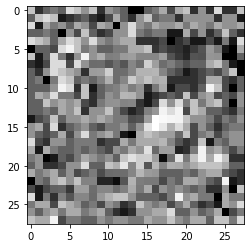

In [21]:
plt.imshow(multistep_attack)
plt.show()

In [22]:
multistep_attack_images = multistep_adversarial_attack(x_train[0:300], y_train_categorical[0:300], 0.1, 0.001, 100)

0


In [23]:
print("Base accuracy on adversarial images:", model.evaluate(x=multistep_attack_images, y=y_train[0:300], verbose=0))
adv_train_predictions = model.predict(multistep_attack_images)

Base accuracy on adversarial images: [17130.3125, 0.0]


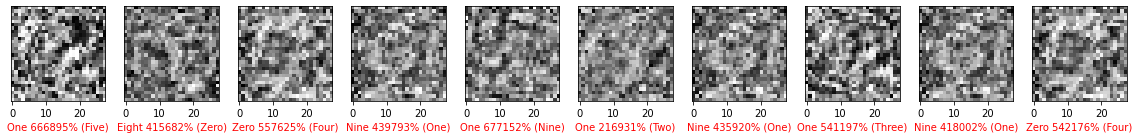

In [24]:
display_images(multistep_attack_images, adv_train_predictions, y_train[0:300])